## 1. Data Collection and Cleaning

### 1.1 Import Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob, Word
from imblearn.over_sampling import ADASYN
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
%matplotlib inline

### 1.2 Load Metacritic Album Review Data

__This data set consists of user reviews that were web scraped from the albums listed on www.metacritic.com. Please refer to the "Metacritic Scraper" notebook in this respository for the code used to collect this data.__

The following are explanations of the features in this dataset

In [2]:
df = pd.read_csv('user_album_reviews.csv', engine='python')

In [3]:
df.head()

Unnamed: 0 Unnamed: 0.1                         title              artist  \
0           0            0   \n\nAgricultural Tragic\n\n           Corb Lund   
1           1            1  \n\nCloser Than Together\n\n  The Avett Brothers   
2           2            2                   \n\nIII\n\n       The Lumineers   
3           3            3                   \n\nIII\n\n       The Lumineers   
4           4            4                   \n\nIII\n\n       The Lumineers   

            label  release_date  metascore user_score    genre  \
0        New West  Jun 26, 2020       80.0    \ntbd\n  Country   
1       Universal  Oct  4, 2019       56.0    \ntbd\n     Folk   
2  Dualtone Music  Sep 13, 2019       72.0    \n8.6\n  Country   
3  Dualtone Music  Sep 13, 2019       72.0    \n8.6\n  Country   
4  Dualtone Music  Sep 13, 2019       72.0    \n8.6\n  Country   

                                             summary              name  \
0  The latest full-length release for the Canadia...  \nKrishnaKniar\n   
1  the 10th full-length studio release for the fo...       \ndjbrate\n   
2  The third full-length release for the Colorado...        \nDididi\n   
3  The third full-length release for the Colorado...  \nbrrunosouzza\n   
4  The third full-length release for the Colorado...    \ngollygee93\n   

           date  rating                                             review  
0  Jul 28, 2020     7.0  \nThis album has a very good vibe and you woul...  
1  Nov 12, 2019     1.0  \nIncredibly disappointed with the political r...  
2  Oct  9, 2019    10.0  \nA literal masterpiece, its so good, very goo...  
3  Sep 25, 2019    10.0  'III' é um dos poucos álbuns que fiquei ansios...  
4  Sep 26, 2019     9.0  Rather than continuing down the path of sample...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84536 entries, 0 to 84535
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    84536 non-null  int64  
 1   Unnamed: 0.1  84536 non-null  object 
 2   title         84054 non-null  object 
 3   artist        84054 non-null  object 
 4   label         83678 non-null  object 
 5   release_date  84054 non-null  object 
 6   metascore     84054 non-null  float64
 7   user_score    84054 non-null  object 
 8   genre         84054 non-null  object 
 9   summary       82742 non-null  object 
 10  name          84054 non-null  object 
 11  date          84054 non-null  object 
 12  rating        84054 non-null  float64
 13  review        84054 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.0+ MB


### 1.3 Data Cleaning

Due to the webscraping process, there are about 500 rows where reviews that had spaces in between paragraphs were made into there own row for each additional paragraph and are located in the 'Unnamed' columns. The remaining columns for those rows were all null so they will be dropped. 

In [5]:
df = df[df['title'].notna()]

In [6]:
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
def dropn(x):
    return x.replace('\n', '')

In [8]:
df['title'] = df['title'].apply(dropn)
df['user_score'] = df['user_score'].apply(dropn)
df['name'] = df['name'].apply(dropn)
df['review'] = df['review'].apply(dropn)

In [9]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['date'] = pd.to_datetime(df['date'])

In [12]:
df = df.sort_values(['genre', 'release_date'], ascending = (True,False)).reset_index(drop = True)

In [13]:
df

title           artist  \
0                                        Continuum       John Mayer   
1                                        Continuum       John Mayer   
2                                        Continuum       John Mayer   
3                                        Continuum       John Mayer   
4                                        Continuum       John Mayer   
...                                            ...              ...   
84049  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84050  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84051  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84052                                 Congotronics     Konono No. 1   
84053                                 Congotronics     Konono No. 1   

               label release_date  metascore user_score              genre  \
0               Sony   2006-09-12       67.0        8.9  Adult Alternative   
1               Sony   2006-09-12       67.0        8.9  Adult Alternative   
2               Sony   2006-09-12       67.0        8.9  Adult Alternative   
3               Sony   2006-09-12       67.0        8.9  Adult Alternative   
4               Sony   2006-09-12       67.0        8.9  Adult Alternative   
...              ...          ...        ...        ...                ...   
84049      Soul Jazz   2006-02-13       93.0        8.3              World   
84050      Soul Jazz   2006-02-13       93.0        8.3              World   
84051      Soul Jazz   2006-02-13       93.0        8.3              World   
84052  Crammed Discs   2005-09-27       87.0        7.2              World   
84053  Crammed Discs   2005-09-27       87.0        7.2              World   

                                                 summary           name  \
0      The singer-songwriter's first album in three y...     ibadukefan   
1      The singer-songwriter's first album in three y...          ToddW   
2      The singer-songwriter's first album in three y...  ChristopherG.   
3      The singer-songwriter's first album in three y...   jfrotylpe532   
4      The singer-songwriter's first album in three y...          ErinY   
...                                                  ...            ...   
84049  This 19-song compiliation from the esteemed So...         billye   
84050  This 19-song compiliation from the esteemed So...          JohnO   
84051  This 19-song compiliation from the esteemed So...         Iky009   
84052  The first installment of a series of "Congotro...         larryl   
84053  The first installment of a series of "Congotro...            MD.   

            date  rating                                             review  
0     2014-02-02    10.0  This is John Mayer in the zone.  This is where...  
1     2006-09-27     1.0   I give Little, Good John kudos for at least t...  
2     2007-08-01     3.0   John Mayer... oh John Mayer. A talented blues...  
3     2012-12-21     8.0  John Mayer brings a great sounding album as a ...  
4     2006-09-12    10.0   It is great to have John Mayer back. This alb...  
...          ...     ...                                                ...  
84049 2006-09-18    10.0             Wonderful compilation. Very impressed.  
84050 2006-11-12    10.0                                      Inspirational  
84051 2014-01-06     9.0                                    Sensacional      
84052 2006-04-12     8.0   8.5......pretty ingratiating. somehow, after ...  
84053 2007-11-18     9.0   An exceptional release from an exceptional ba...  

[84054 rows x 12 columns]

In [14]:
def clean_rev(text):
    text = text.str.replace("<br/>", "")
    text = text.str.replace("'", '')
    text = text.str.replace("-", '')
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('&amp', '')
    text = text.str.replace('&gt', '')
    text = text.str.replace('&lt', '')
    text = text.str.replace('\xa0', ' ')
    text = text.str.replace('[^\w\s]', ' ')
    text = text.str.replace('[0-9]', ' ')
    text = text.str.lower() 
    return text
df['clean_review'] = clean_rev(df['review'])

In [166]:
df['clean_review'] = clean_rev(df['review'])

## 2. Preprocessing & Feature Engineering

In [178]:
stopwords_list=stopwords.words('english')+list(string.punctuation)+['album','song', 'music']

In [168]:
df['clean_review'] = df['clean_review'].apply(lambda text_list: ' '.join([x for x in text_list.split() if x not in stopwords_list]))

In [16]:
df['length'] = df['review'].astype(str).apply(len)
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

Classifying review sentiment using Vader

In [17]:
analyzer = SentimentIntensityAnalyzer()


In [18]:
df['sentiment'] = [analyzer.polarity_scores(x)['compound'] for x in df['clean_review']]
df['negative'] = [analyzer.polarity_scores(x)['neg'] for x in df['clean_review']]
df['neutral'] = [analyzer.polarity_scores(x)['neu'] for x in df['clean_review']]
df['positive'] = [analyzer.polarity_scores(x)['pos'] for x in df['clean_review']]

In [25]:
df['sent_class'] = np.where(df['sentiment'] >= 0.05, 1, df['sentiment'])
df['sent_class'] = np.where((df['sentiment'] > -0.05) & (df['sentiment'] < 0.05), 0, df['sent_class'])
df['sent_class'] = np.where(df['sentiment'] <= -0.05, -1, df['sent_class'])

Tokenize

In [20]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')



In [24]:
#function to remove all stopwords, punctuations & unimportant words from the reviews and make a list
def reduce(text):
    tokens = tokenizer.tokenize(text) # tokenize every review
    removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return removed

In [236]:
clean_reviews = df['clean_review']
target = df['sent_class']

In [237]:
# remove all stopwords, punctuations & unimportant words from the reviews and make a list
processed_data = list(map(reduce, clean_reviews))

Lemmatization

In [238]:
lemmatizer = WordNetLemmatizer()

In [239]:
lem_review = []
for j in processed_data:
    lem = ' '.join([lemmatizer.lemmatize(w) for w in j])
    lem_review.append(lem)

TF-IDF

In [240]:
XL = lem_review
yL = target

In [241]:
XL_train, XL_test, yL_train, yL_test = train_test_split(XL, yL, test_size=0.2, random_state=1)
tfVectorizer = TfidfVectorizer()

XL_train_tf = tfVectorizer.fit_transform(XL_train)
XL_test_tf = tfVectorizer.transform(XL_test)

## 3. EDA

In [106]:
df.sent_class.value_counts()

 1.0    65157
-1.0    12814
 0.0     6083
Name: sent_class, dtype: int64

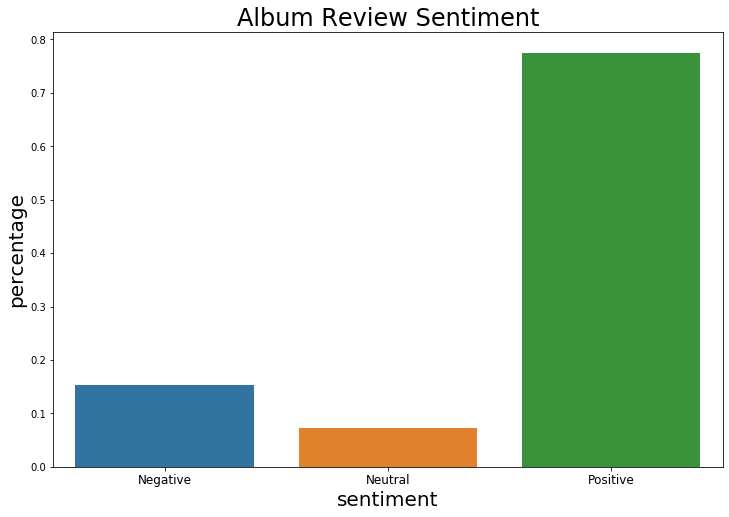

In [263]:
plt.figure(figsize=(12,8))
sns.barplot(df.sent_class.value_counts(normalize=True).index, 
            df.sent_class.value_counts(normalize=True).values)
plt.xlabel('sentiment', fontsize=20)
plt.ylabel('percentage', fontsize=20)
plt.title('Album Review Sentiment', fontsize=24)
plt.xticks(ticks = [0, 1, 2], labels = ['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.savefig('sent_class.png')


In [196]:
df.genre.value_counts()

Rock                 25773
Indie                17871
Rap                  14975
Pop                  12165
Electronic            5419
R&B                   2808
Country               1637
Dance                 1443
Folk                   442
Alternative            383
Latin                  193
Adult Alternative      151
Jazz                   139
World                  121
Bluegrass               77
Soundtrack              75
Metal                   59
Reggae                  58
Punk                    51
Experimental            42
Comedy                  40
Alt-Country             34
Blues                   30
House                   29
Soul                    28
Singer-Songwriter        5
Live                     3
Adult-Alternative        2
Singer/Songwriter        1
Name: genre, dtype: int64

In [212]:
top = ['Rock', 'Indie', 'Rap', 'Pop', 'Electronic']

In [214]:
df_top = df.loc[df['genre'].isin(top)]

In [215]:
df_top

title       artist  \
3797   None of Us Are Getting out of This Life Alive  The Streets   
3798                                   Feel Feelings         Soko   
3799                   1000 gecs & the Tree of Clues     100 gecs   
3800                   1000 gecs & the Tree of Clues     100 gecs   
3801                   1000 gecs & the Tree of Clues     100 gecs   
...                                              ...          ...   
83819                                             13         Blur   
83820                                             13         Blur   
83821                                             13         Blur   
83822                                             13         Blur   
83823                            Central Reservation   Beth Orton   

               label release_date  metascore user_score       genre  \
3797          Island   2020-07-10       75.0        tbd  Electronic   
3798   Because Music   2020-07-10       70.0        tbd  Electronic   
3799        Big Beat   2020-07-10       81.0        7.8  Electronic   
3800        Big Beat   2020-07-10       81.0        7.8  Electronic   
3801        Big Beat   2020-07-10       81.0        7.8  Electronic   
...              ...          ...        ...        ...         ...   
83819    Food/Virgin   1999-03-23       79.0        8.7        Rock   
83820    Food/Virgin   1999-03-23       79.0        8.7        Rock   
83821    Food/Virgin   1999-03-23       79.0        8.7        Rock   
83822    Food/Virgin   1999-03-23       79.0        8.7        Rock   
83823         Arista   1999-03-09       84.0        8.4        Rock   

                                                 summary           name  \
3797   The first full-length release in nearly 10 yea...          Btsew   
3798   The third full-length release for the Los Ange...   reoffender59   
3799   The remix album from the experimental pop duo ...       ztuxilef   
3800   The remix album from the experimental pop duo ...         hazsch   
3801   The remix album from the experimental pop duo ...   sammyanthony   
...                                                  ...            ...   
83819  Damon Albarn's breakup album (he split with hi...  Dan_Abnormal_   
83820  Damon Albarn's breakup album (he split with hi...           MCRR   
83821  Damon Albarn's breakup album (he split with hi...        rextree   
83822  Damon Albarn's breakup album (he split with hi...     MoonNGloom   
83823  This is the second album for the English singe...         RussL.   

            date  ...                                       clean_review  \
3797  2020-07-18  ...  posners best work since grand dont come free q...   
3798  2020-07-12  ...  great great dream pop strong character also fl...   
3799  2020-07-15  ...  hey lil piss baby think youre cool huh think t...   
3800  2020-07-19  ...  hold isnt gex gec gec gec gec gec gec gec gec ...   
3801  2020-07-12  ...  gecgecgecgecgecgecgecgecgecgecgecgecgecgecgecg...   
...          ...  ...                                                ...   
83819 2013-09-08  ...  surprise blur another change direction lofi pr...   
83820 2015-01-25  ...  blur albarns resume consists quality recording...   
83821 2019-02-19  ...  beautiful underrated masterpiece earcandy soun...   
83822 2019-03-27  ...  beautiful heartbreaking strange yet ever endea...   
83823 2006-08-15  ...  alltime favorite cd unique sound combining gre...   

      length word_count  sentiment  negative  neutral  positive  sent_class  \
3797     200         34     0.8315     0.063    0.694     0.243         1.0   
3798      94         17     0.9501     0.000    0.436     0.564         1.0   
3799     328         67     0.9147     0.087    0.694     0.220         1.0   
3800      73         17     0.0000     0.000    1.000     0.000         0.0   
3801     300          1     0.0000     0.000    1.000     0.000         0.0   
...      ...        ...        ...       ...      ...       ...         ...  

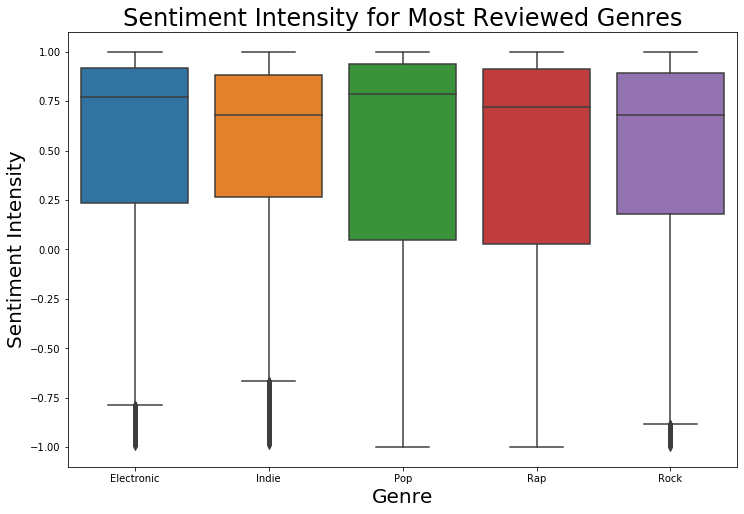

In [262]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'genre', y = 'sentiment', data = df_top)
plt.xlabel('Genre', fontsize=20)
plt.ylabel('Sentiment Intensity', fontsize=20)
plt.title('Sentiment Intensity for Most Reviewed Genres', fontsize=24)
plt.savefig('sent_intense.png')


In [158]:
df.rating.describe()

count    84054.000000
mean         7.961132
std          2.916413
min          0.000000
25%          7.000000
50%          9.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

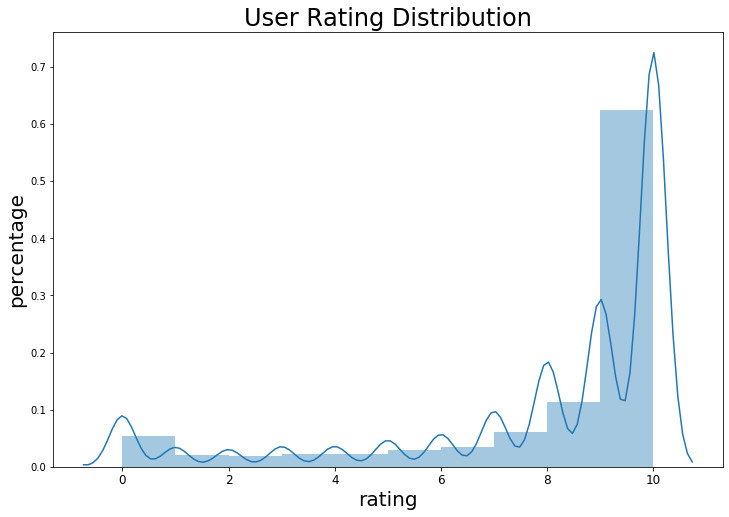

In [264]:
plt.figure(figsize=(12,8))
sns.distplot(df.rating, bins=10)
plt.xlabel('rating', fontsize=20)
plt.ylabel('percentage', fontsize=20)
plt.title('User Rating Distribution', fontsize=24)
plt.xticks(fontsize=12)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text xticklabel objects>)

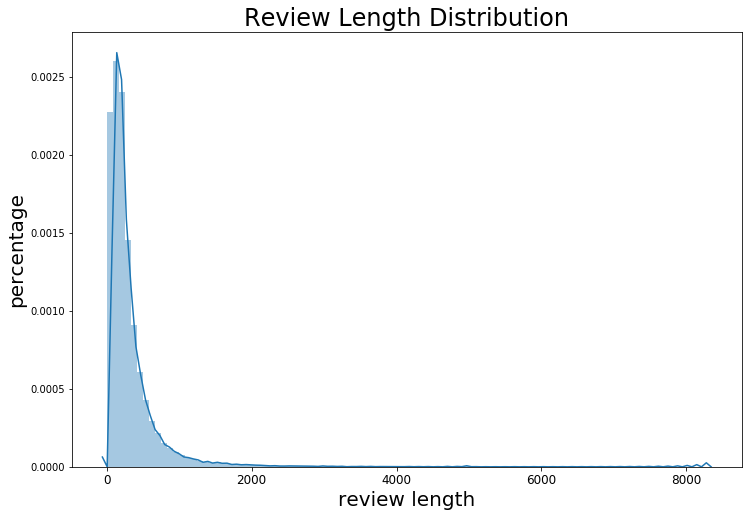

In [265]:
plt.figure(figsize=(12,8))
sns.distplot(df.length, bins=100)
plt.xlabel('review length', fontsize=20)
plt.ylabel('percentage', fontsize=20)
plt.title('Review Length Distribution', fontsize=24)
plt.xticks(fontsize=12)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]),
 <a list of 11 Text xticklabel objects>)

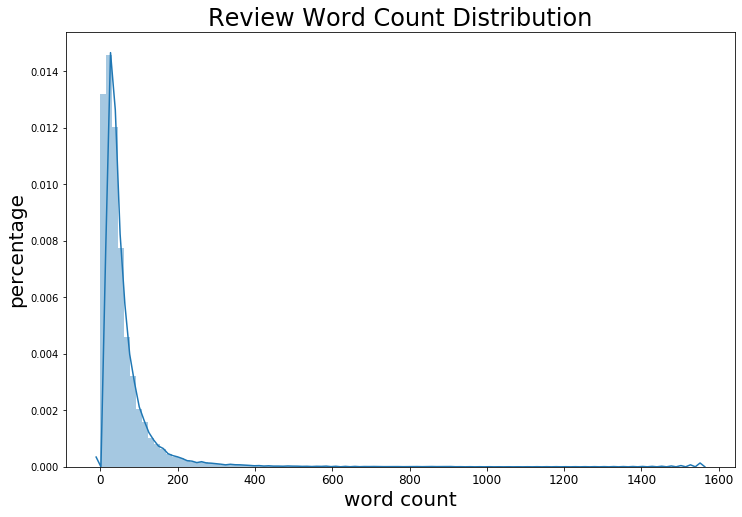

In [266]:
plt.figure(figsize=(12,8))
sns.distplot(df.word_count, bins=100)
plt.xlabel('word count', fontsize=20)
plt.ylabel('percentage', fontsize=20)
plt.title('Review Word Count Distribution', fontsize=24)
plt.xticks(fontsize=12)

### 3.3 Bigrams and Trigrams for each class

In [130]:
from sklearn.feature_extraction.text import CountVectorizer  #function to get the top text n_grams
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range = (g, g), stop_words=stopwords_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

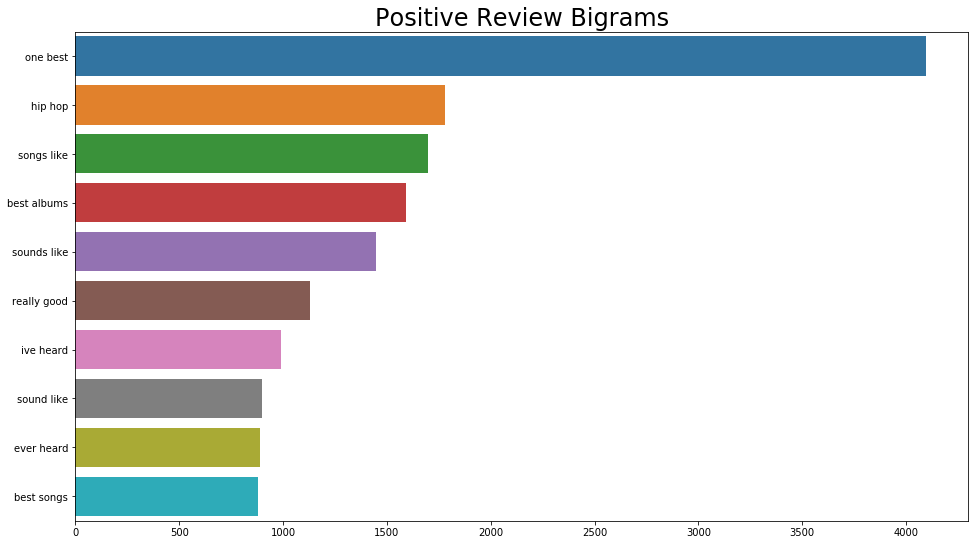

In [267]:
plt.figure(figsize = (16, 9))
top_bigrams = get_top_text_ngrams(df[df.sent_class == 1].clean_review, 10, 2)
top_bigrams = dict(top_bigrams)
sns.barplot(x = list(top_bigrams.values()), y = list(top_bigrams.keys()))
plt.title('Positive Review Bigrams', fontsize=24)
plt.savefig('pos_bi.png')


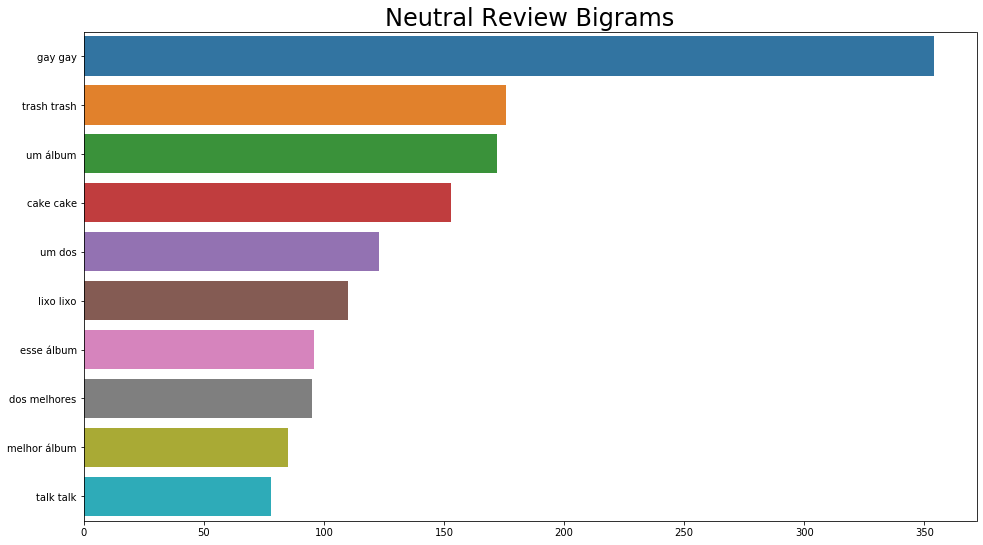

In [268]:
plt.figure(figsize = (16, 9))
top_bigrams = get_top_text_ngrams(df[df.sent_class == 0].clean_review, 10, 2)
top_bigrams = dict(top_bigrams)
sns.barplot(x = list(top_bigrams.values()), y = list(top_bigrams.keys()))
plt.title('Neutral Review Bigrams', fontsize=24)
plt.savefig('neu_bi.png')


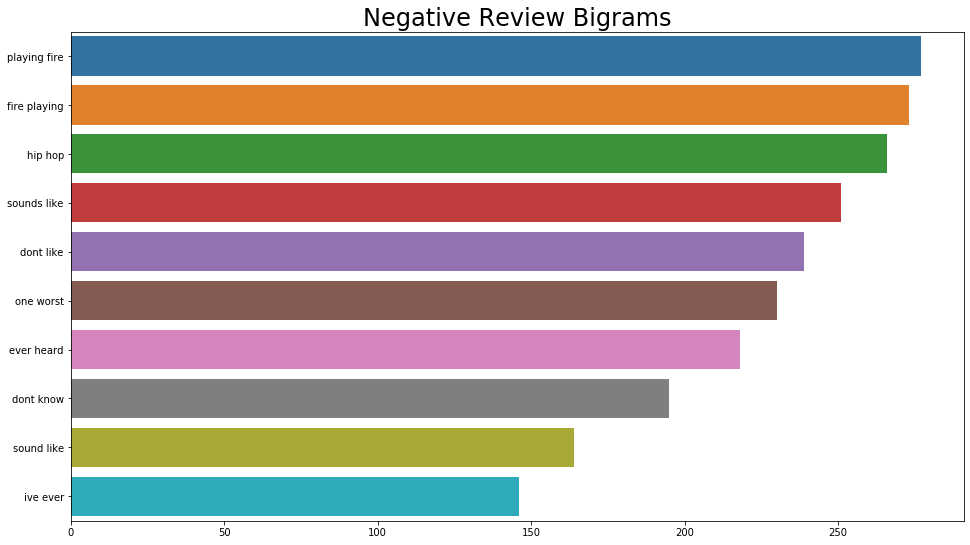

In [269]:
plt.figure(figsize = (16, 9))
top_bigrams = get_top_text_ngrams(df[df.sent_class == -1].clean_review, 10, 2)
top_bigrams = dict(top_bigrams)
sns.barplot(x = list(top_bigrams.values()), y = list(top_bigrams.keys()))
plt.title('Negative Review Bigrams', fontsize=24)
plt.savefig('neg_bi.png')


Trigrams

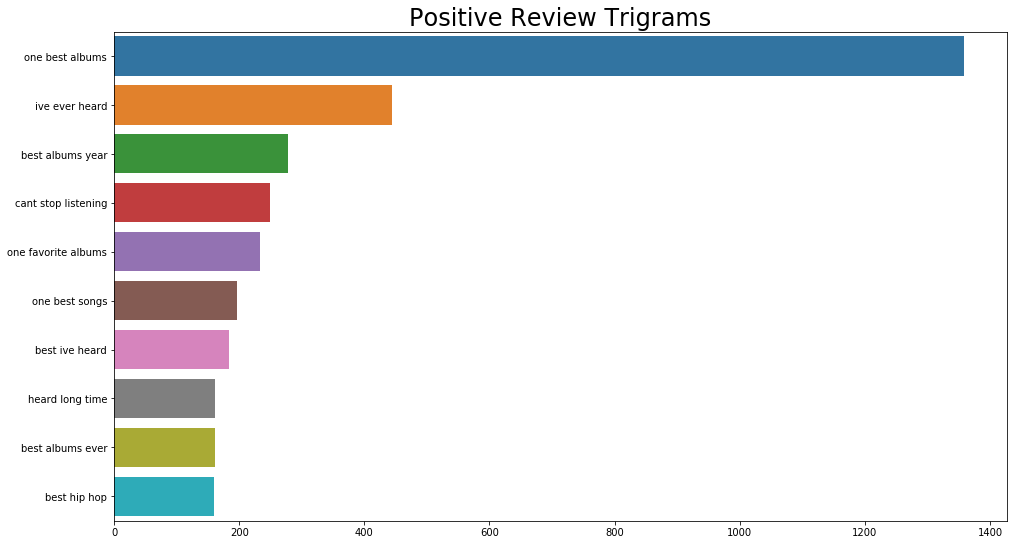

In [270]:
plt.figure(figsize = (16, 9))
top_trigrams = get_top_text_ngrams(df[df.sent_class == 1].clean_review, 10, 3)
top_trigrams = dict(top_trigrams)
sns.barplot(x = list(top_trigrams.values()), y = list(top_trigrams.keys()))
plt.title('Positive Review Trigrams', fontsize=24)
plt.savefig('pos_tri.png')


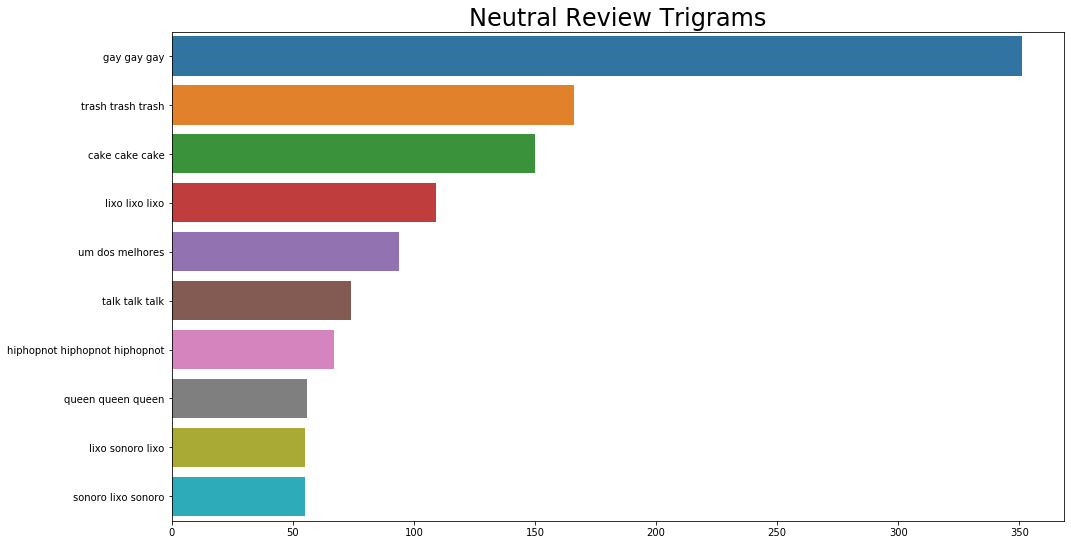

In [271]:
plt.figure(figsize = (16, 9))
top_trigrams = get_top_text_ngrams(df[df.sent_class == 0].clean_review, 10, 3)
top_trigrams = dict(top_trigrams)
sns.barplot(x = list(top_trigrams.values()), y = list(top_trigrams.keys()))
plt.title('Neutral Review Trigrams', fontsize=24)
plt.savefig('neu_tri.png')


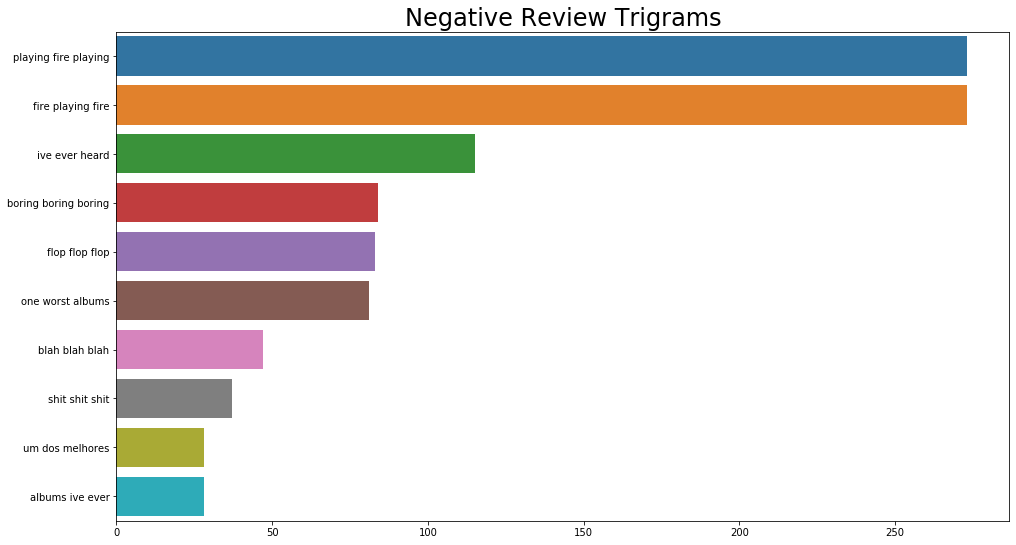

In [272]:
plt.figure(figsize = (16, 9))
top_bigrams = get_top_text_ngrams(df[df.sent_class == -1].clean_review, 10, 3)
top_bigrams = dict(top_bigrams)
sns.barplot(x = list(top_bigrams.values()), y = list(top_bigrams.keys()))
plt.title('Negative Review Trigrams', fontsize=24)
plt.savefig('neg_tri.png')


### 3.4 Word Cloud for each class

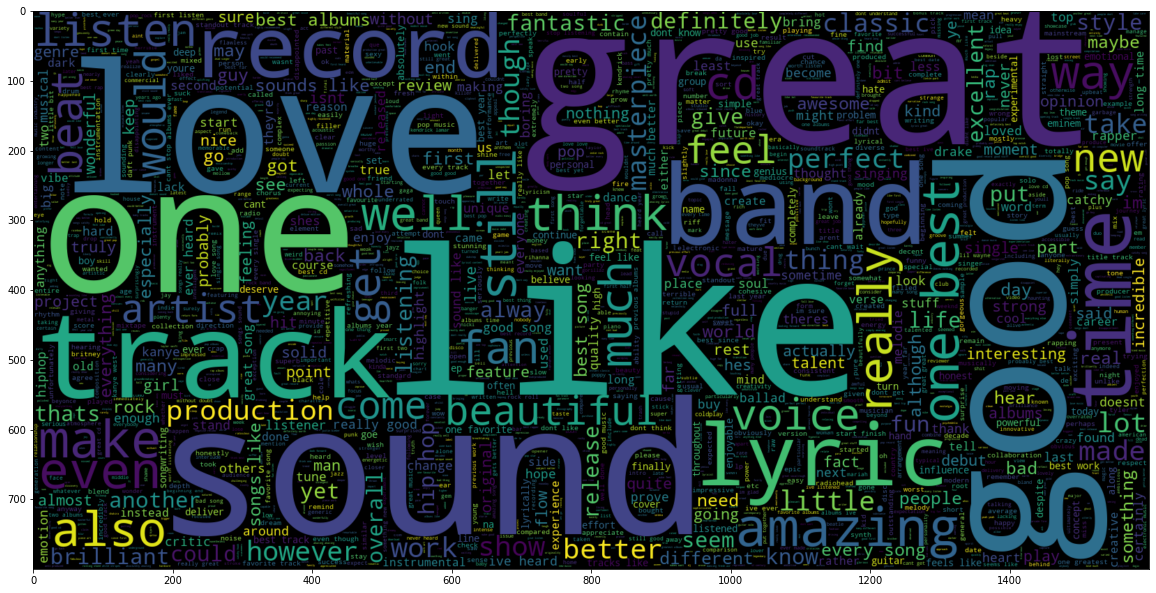

In [292]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df[df.sent_class == 1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('word_pos.png')


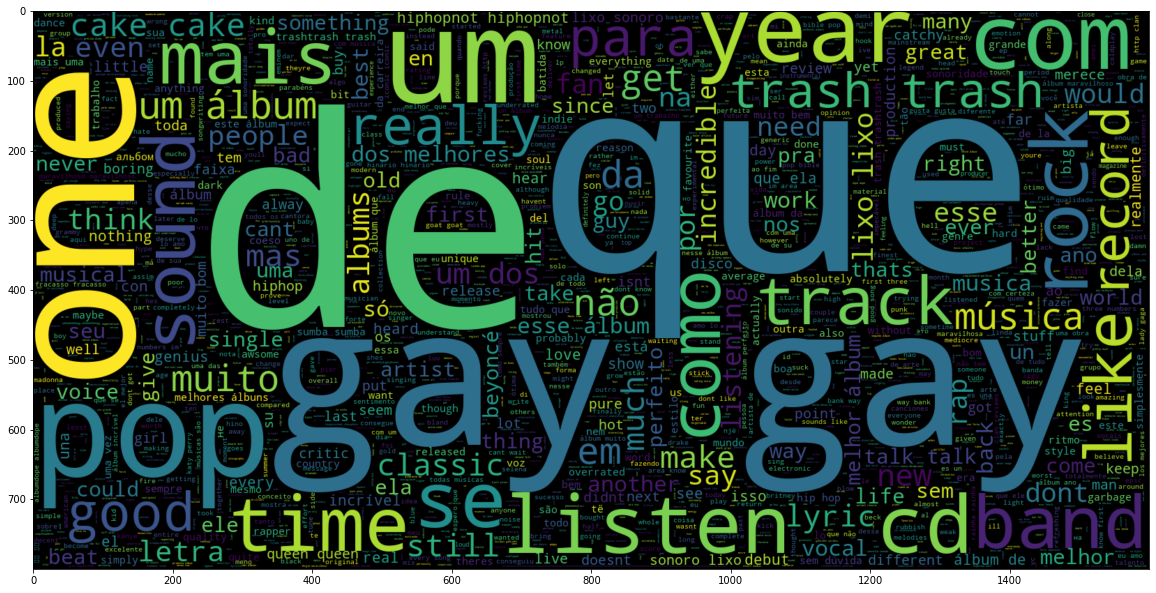

In [274]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df[df.sent_class == 0].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('word_neu.png')


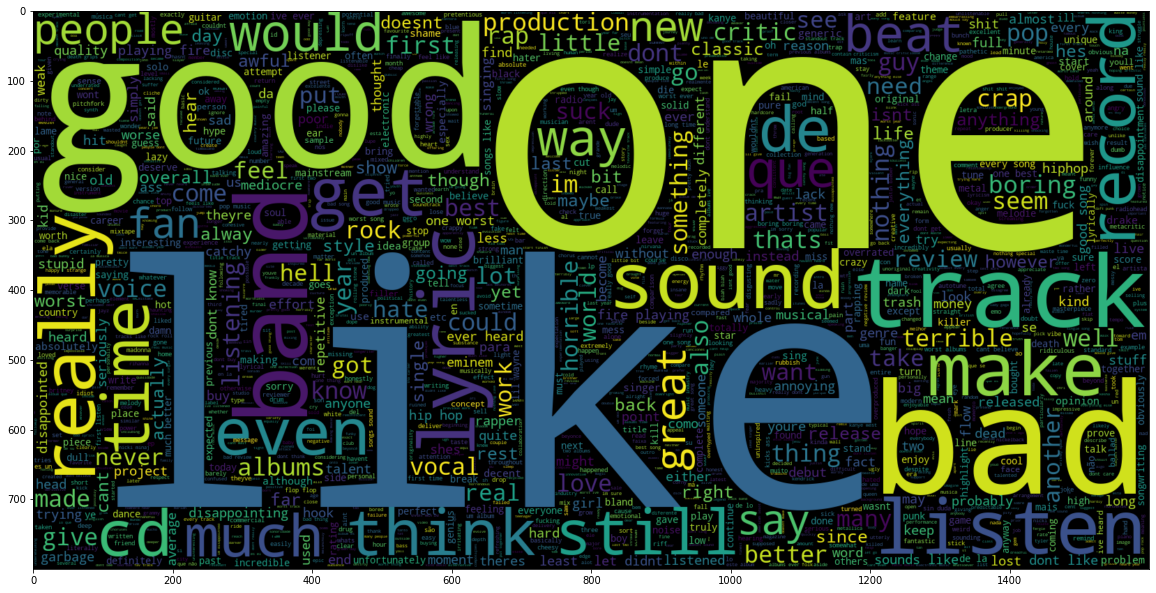

In [275]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df[df.sent_class == -1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('word_neg.png')

### 3.5 Word Clouds for Rock and Rap

These two generes were chosen specifically as they are have the top 3 most reviews and greater differences in musicial style compared to Rock vs Indie

Rock

In [230]:
df_rock = df.loc[df.genre == 'Rock']

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



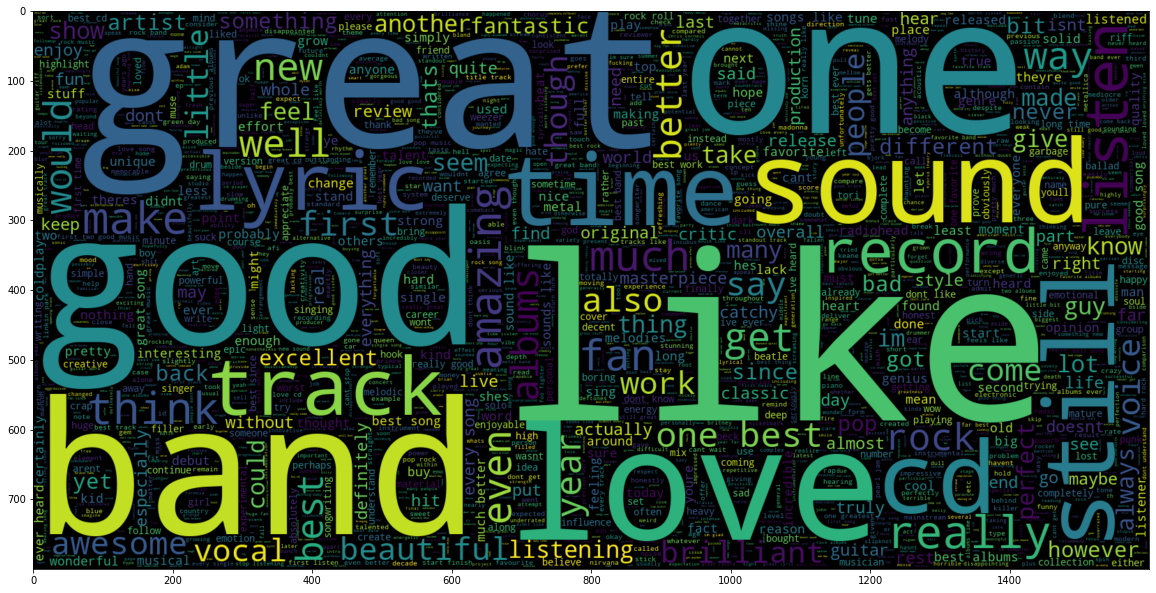

In [276]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rock[df.sent_class == 1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rock_pos.png')

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



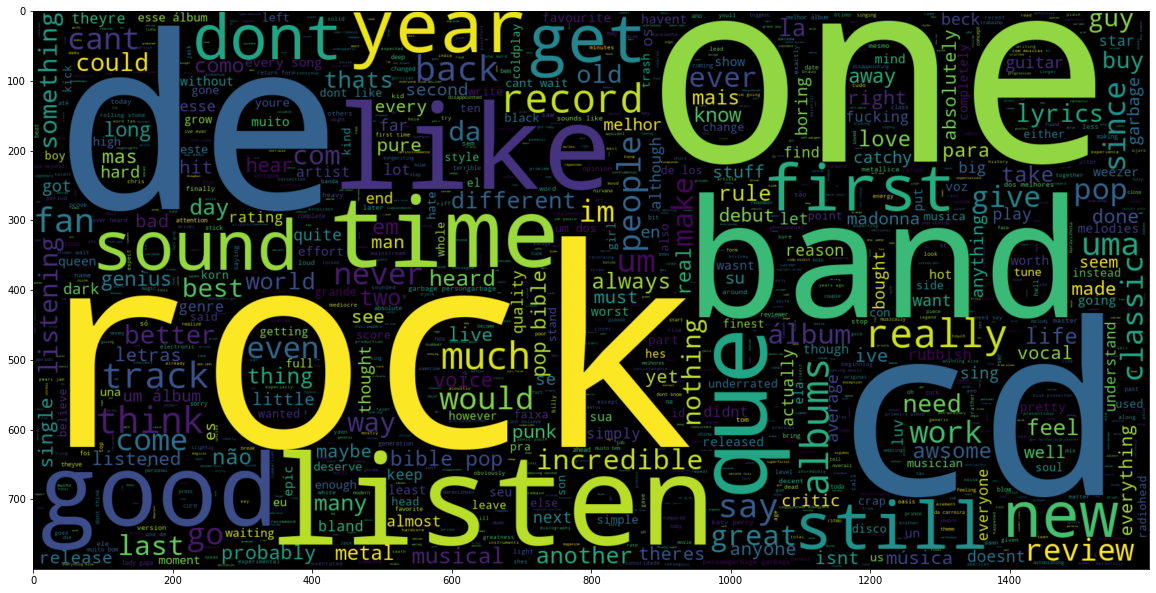

In [278]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rock[df.sent_class == 0].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rock_neu.png')

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



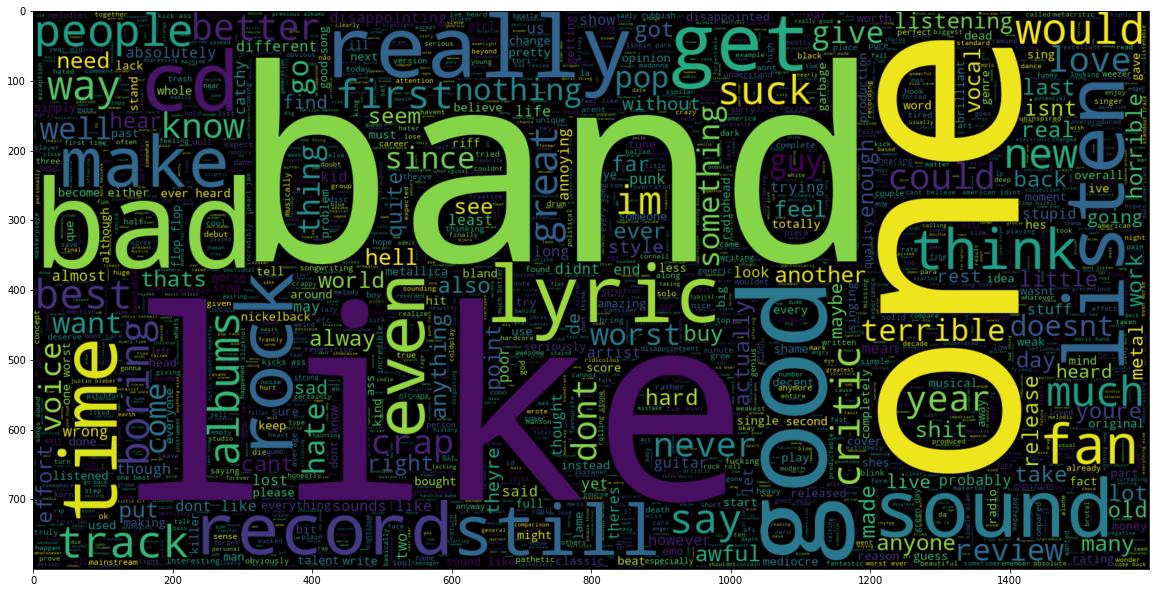

In [277]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rock[df.sent_class == -1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rock_neg.png')

Rap

In [232]:
df_rap = df.loc[df.genre == 'Rap']

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



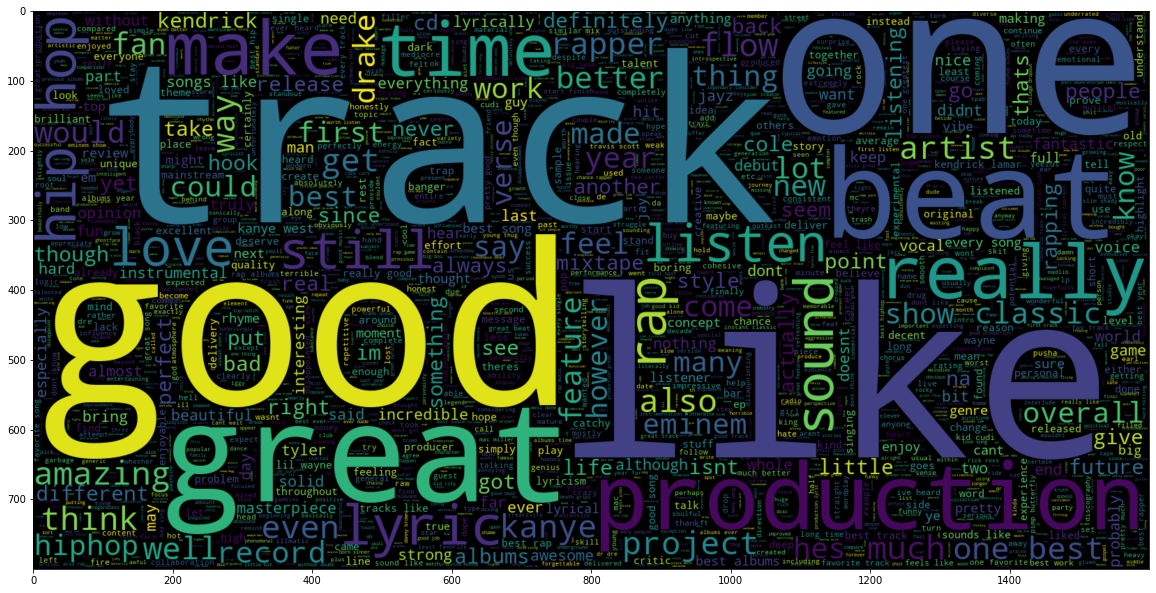

In [279]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rap[df.sent_class == 1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rap_pos.png')


/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



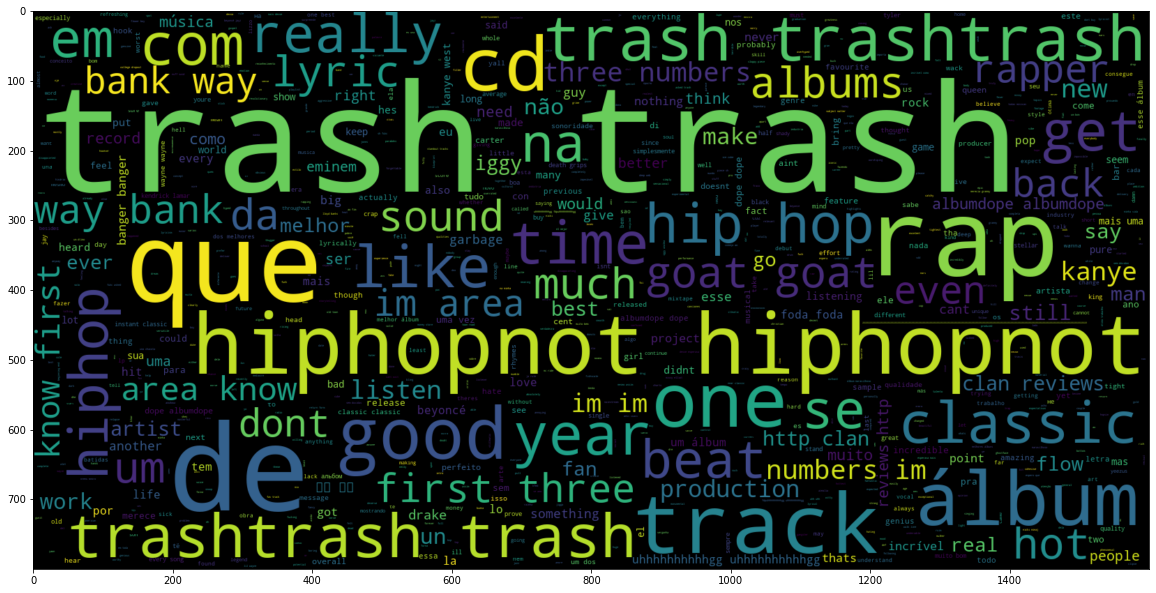

In [281]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rap[df.sent_class == 0].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rap_neu.png')

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



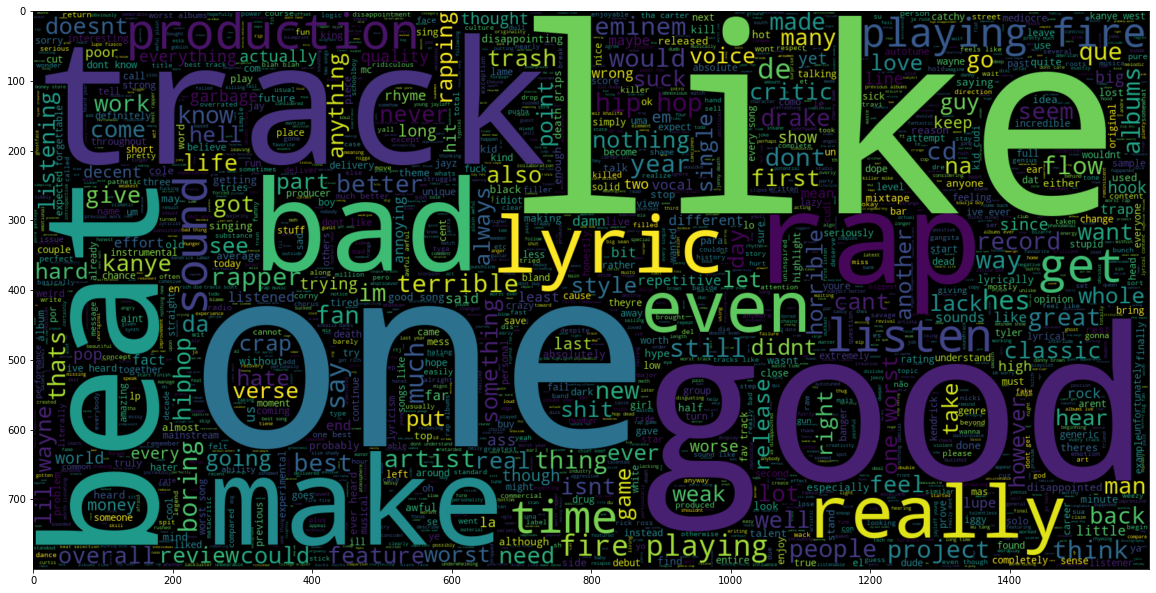

In [280]:
plt.figure(figsize = (20,20)) # Text that is True
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stopwords_list).generate(" ".join(df_rap[df.sent_class == -1].clean_review))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('rap_neg.png')

## 4 Modeling

### 4.1 Baseline Model

In [242]:
#Fitting & predicting the Dummy Classifier (Baseline Model)
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier() 

In [243]:
dclf.fit(XL_train_tf, yL_train)
y_preds_b = dclf.predict(XL_test_tf)
print('dummy accuracy:',accuracy_score(yL_test, yL_preds),
      'dummy forest f1:',f1_score(yL_test, yL_preds, average = 'weighted'))

dummy accuracy: 0.7775266194753435 dummy forest f1: 0.6802121975210639


/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



### 4.2 RF, NB, & SVM

In [244]:
rf_classifier = RandomForestClassifier(n_estimators=250)

In [245]:
startTime = datetime.now()

rf_classifier.fit(XL_train_tf, yL_train)
yL_preds = rf_classifier.predict(XL_test_tf)
print('random forest accuracy:',accuracy_score(yL_test, yL_preds),
      'random forest f1:',f1_score(yL_test, yL_preds, average = 'weighted'))
print(datetime.now() - startTime)

random forest accuracy: 0.8483136041877343 random forest f1: 0.8187752798800013
0:10:20.744936


In [246]:
nb_classifier = MultinomialNB()

In [247]:
startTime = datetime.now()

nb_classifier.fit(XL_train_tf, yL_train)
yL_preds = nb_classifier.predict(XL_test_tf)
print('naive bayes accuracy:',accuracy_score(yL_test, yL_preds),
      'naive bayes f1:',f1_score(yL_test, yL_preds, average = 'weighted'))
print(datetime.now() - startTime)

naive bayes accuracy: 0.7891261673903991 naive bayes f1: 0.7181244208947789
0:00:00.256256


In [248]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel='linear', C= 1.0)

In [249]:
startTime = datetime.now()

svc_classifier.fit(XL_train_tf, yL_train)
yL_preds = svc_classifier.predict(XL_test_tf)
print('support vector machine accuracy:',accuracy_score(yL_test, yL_preds),
      'support vector machine f1:',f1_score(yL_test, yL_preds, average = 'weighted'))
print(datetime.now() - startTime)

support vector machine accuracy: 0.8836476116828267 support vector machine f1: 0.8771486600312914
0:26:26.633610


In [290]:
svc1_classifier = SVC(kernel='rbf', C = 0.1, gamma = 'auto')

In [293]:
startTime = datetime.now()

svc1_classifier.fit(XL_train_tf, yL_train)
yL_preds = svc1_classifier.predict(XL_test_tf)
print('support vector machine accuracy:',accuracy_score(yL_test, yL_preds),
      'support vector machine f1:',f1_score(yL_test, yL_preds, average = 'weighted'))
print(datetime.now() - startTime)

support vector machine accuracy: 0.7775266194753435 support vector machine f1: 0.6802121975210639
0:09:05.334177


### 4.3 Grid SearchCV Naive Bayes Model

In [250]:
from sklearn.model_selection import GridSearchCV

In [251]:
nb_params = {'alpha': [0.01,0.03,0.05,0.07,0.09,0.11,0.13,0.15,0.17,0.19],
              'fit_prior': [True, False],
              'class_prior': [[-1,0,1],[1,0,-1]]}

In [252]:
grid_nb = GridSearchCV(nb_classifier, param_grid=nb_params, cv=7, scoring='accuracy', verbose =1, n_jobs=-1)
grid_nb.fit(XL_train_tf, yL_train)

Fitting 7 folds for each of 40 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    9.8s finished
/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning:

divide by zero encountered in log

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning:

invalid value encountered in log



GridSearchCV(cv=7, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13,
                                   0.15, 0.17, 0.19],
                         'class_prior': [[-1, 0, 1], [1, 0, -1]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=1)

In [253]:
# examine the best model
print(grid_nb.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_nb.best_params_)
# Shows default parameters that we did not specify
print(grid_nb.best_estimator_)
#Identify the best score during fitting with cross-validation

0.7745936388061276
{'alpha': 0.01, 'class_prior': [1, 0, -1], 'fit_prior': True}
MultinomialNB(alpha=0.01, class_prior=[1, 0, -1])


In [254]:
yL_preds = grid_nb.best_estimator_.predict(XL_test_tf)
print('naive bayes accuracy:',accuracy_score(yL_test, yL_preds),
      'naive bayes f1:',f1_score(yL_test, yL_preds, average = 'weighted'))

naive bayes accuracy: 0.7775266194753435 naive bayes f1: 0.6802121975210639


### 4.4 Modeling with spaCy

Modeling with was spaCy was used to try to better process the large amount of text in the data and handle the context of the review and see if it resulted in better performing models.

In [255]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups


In [256]:
sp = spacy.load('en_core_web_md')
lookups = Lookups()
lemm = Lemmatizer(lookups)

In [257]:
def lem_function(text):
    dummy = []
    #this is just a test to see if it works
    for word in sp(text):
        dummy.append(word.lemma_)
    return ' '.join(dummy)


In [258]:
from tqdm import tqdm

In [259]:
tqdm.pandas()

/Users/danielmocombe/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [282]:
df['sp_lm'] = df['clean_review'].progress_apply(lambda x: lem_function(x))

100%|██████████| 84054/84054 [16:40<00:00, 84.00it/s] 


In [283]:
df['sp_lm'] = df['sp_lm'].progress_apply(lambda x: x.replace('-PRON-', ' '))

100%|██████████| 84054/84054 [00:00<00:00, 186391.53it/s]


In [98]:
df

title           artist  \
0                                        Continuum       John Mayer   
1                                        Continuum       John Mayer   
2                                        Continuum       John Mayer   
3                                        Continuum       John Mayer   
4                                        Continuum       John Mayer   
...                                            ...              ...   
84049  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84050  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84051  Tropicalia: A Brazilian Revolution In Sound  Various Artists   
84052                                 Congotronics     Konono No. 1   
84053                                 Congotronics     Konono No. 1   

               label release_date  metascore user_score              genre  \
0               Sony   2006-09-12       67.0        8.9  Adult Alternative   
1               Sony   2006-09-12       67.0        8.9  Adult Alternative   
2               Sony   2006-09-12       67.0        8.9  Adult Alternative   
3               Sony   2006-09-12       67.0        8.9  Adult Alternative   
4               Sony   2006-09-12       67.0        8.9  Adult Alternative   
...              ...          ...        ...        ...                ...   
84049      Soul Jazz   2006-02-13       93.0        8.3              World   
84050      Soul Jazz   2006-02-13       93.0        8.3              World   
84051      Soul Jazz   2006-02-13       93.0        8.3              World   
84052  Crammed Discs   2005-09-27       87.0        7.2              World   
84053  Crammed Discs   2005-09-27       87.0        7.2              World   

                                                 summary           name  \
0      The singer-songwriter's first album in three y...     ibadukefan   
1      The singer-songwriter's first album in three y...          ToddW   
2      The singer-songwriter's first album in three y...  ChristopherG.   
3      The singer-songwriter's first album in three y...   jfrotylpe532   
4      The singer-songwriter's first album in three y...          ErinY   
...                                                  ...            ...   
84049  This 19-song compiliation from the esteemed So...         billye   
84050  This 19-song compiliation from the esteemed So...          JohnO   
84051  This 19-song compiliation from the esteemed So...         Iky009   
84052  The first installment of a series of "Congotro...         larryl   
84053  The first installment of a series of "Congotro...            MD.   

            date  ...                                       clean_review  \
0     2014-02-02  ...  this is john mayer in the zone   this is where...   
1     2006-09-27  ...   i give little  good john kudos for at least t...   
2     2007-08-01  ...   john mayer    oh john mayer  a talented blues...   
3     2012-12-21  ...  john mayer brings a great sounding album as a ...   
4     2006-09-12  ...   it is great to have john mayer back  this alb...   
...          ...  ...                                                ...   
84049 2006-09-18  ...             wonderful compilation  very impressed    
84050 2006-11-12  ...                                      inspirational   
84051 2014-01-06  ...                                    sensacional       
84052 2006-04-12  ...            pretty ingratiating  somehow  after ...   
84053 2007-11-18  ...   an exceptional release from an exceptional ba...   

      length word_count  sentiment  negative  neutral  positive  sent_class  \
0        441         83     0.7227     0.026    0.890     0.083         1.0   
1        575        102     0.1878     0.113    0.767     0.120         1.0   
2        653        117     0.9601     0.039    0.789     0.172         1.0   
3        108         20     0.7964     0.000    0.677     0.323         1.0   
4        123         22     0.9001     0.000  

In [284]:
XS = df['sp_lm']
yS = target

In [285]:
XS_train, XS_test, yS_train, yS_test = train_test_split(XS, yS, test_size=0.2, random_state=1)
tfVectorizer = TfidfVectorizer()

XS_train_tf = tfVectorizer.fit_transform(XS_train)
XS_test_tf = tfVectorizer.transform(XS_test)

In [286]:
rf_classifier = RandomForestClassifier(n_estimators=250)

In [287]:
startTime = datetime.now()

rf_classifier.fit(XS_train_tf, yS_train)
yS_preds = rf_classifier.predict(XS_test_tf)
print('random forest accuracy:',accuracy_score(yS_test, yS_preds),
      'random forest f1:',f1_score(yS_test, yS_preds, average = 'weighted'))
print(datetime.now() - startTime)

random forest accuracy: 0.8442091487716377 random forest f1: 0.8118063633620143
0:11:11.467221


In [288]:
nb_classifier = MultinomialNB()

In [289]:
startTime = datetime.now()

nb_classifier.fit(XS_train_tf, yS_train)
yS_preds = nb_classifier.predict(XS_test_tf)
print('naive bayes accuracy:',accuracy_score(yS_test, yS_preds),
      'naive bayes f1:',f1_score(yS_test, yS_preds, average = 'weighted'))
print(datetime.now() - startTime)

naive bayes accuracy: 0.7901968948902505 naive bayes f1: 0.7201545689790858
0:00:00.172629


In [294]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel='linear', C = 1.0)

In [295]:
startTime = datetime.now()

svc_classifier.fit(XS_train_tf, yS_train)
yS_preds = svc_classifier.predict(XS_test_tf)
print('support vector machine accuracy:',accuracy_score(yS_test, yL_preds),
      'support vector machine f1:',f1_score(yS_test, yS_preds, average = 'weighted'))
print(datetime.now() - startTime)

support vector machine accuracy: 0.7775266194753435 support vector machine f1: 0.8747748851060618
0:19:09.058471
